In [1]:
%matplotlib inline

import requests
import numpy
import shapely, shapely.geometry
import descartes
import h5py
import textwrap
import os
import hashlib
import matplotlib.pyplot as plt
from lxml import etree
import rasterio

In [2]:
def _unwrap(query_result, unwrap=True):
    """ Unwrap a query result.
        
        Parameters:
            query_result - the query result from xpath
            unwrap - whether to unwrap or not
        
        Returns: 
            If there's only one match and unwrap=True, then the 
            etree.Element is returned directly, rather than in a 
            list. If there's no matches and unwrap=True, then the
            function returns None. 

            If unwrap=False, then this always returns a list.
    """
    # Exit straight away if we're not unwrapping
    if not unwrap:
        return query_result
    
    # Return based on length
    length = len(query_result)
    if length == 1:
        return query_result[0]
    elif length > 1:
        return query_result
    else:
        return None
        

def xpath(tree, query, unwrap=True):
    """ Perform a namespace-resolved XPath query on a given tree
    
        Parameters:
            tree - the lxml.etree instance to query
            query - the XPath query
            unwrap - whether to unwrap the result. If there's only
                one match and unwrap=True, then the etree.Element is returned
                directly, rather than in a list. If unwrap=False, then 
                this always returns a list.
        
        Returns:
            a list of matching elements from the tree. 
    """
    ns = dict(namespaces = {
        "ows": "http://www.opengis.net/ows",
        "ogc": "http://www.opengis.net/ogc",
        "wfs": "http://www.opengis.net/wfs",
        "wcs": "http://www.opengis.net/wcs",
        "gml": "http://www.opengis.net/gml",
        "gsml": "urn:cgi:xmlns:CGI:GeoSciML:2.0",
        "sa": "http://www.opengis.net/sampling/1.0",
        "xlink": "http://www.w3.org/1999/xlink",
        "xsi": "http://www.w3.org/2001/XMLSchema-instance"
    })
    return _unwrap(tree.xpath(query, **ns), unwrap=unwrap)

In [3]:
url = 'http://www.ga.gov.au/gisimg/services/topography/dem_h_1s/ImageServer/WCSServer'
get_wcs_capabilities = {
    "service": "wcs",
    "request": "GetCapabilities"
}

response = requests.get(url, params=get_wcs_capabilities)
response.raise_for_status()
capabilities = etree.fromstring(response.content)
describe_coverage_url = xpath(capabilities, './/wcs:DescribeCoverage//wcs:Get//@xlink:href')
get_coverage_url = xpath(capabilities, './/wcs:GetCoverage//wcs:Get//@xlink:href')

Now we can request some information about the layers that are available

In [4]:
describe_coverage_url

'http://www.ga.gov.au/gisimg/services/topography/dem_h_1s/ImageServer/WCSServer'

In [5]:
params = {
    "service": "wcs",
    "request": "DescribeCoverage",
    "version": capabilities.attrib['version']
}
response = requests.get(describe_coverage_url, params=params)
response.raise_for_status()
descriptions = etree.fromstring(response.content)

layer = xpath(descriptions, './wcs:CoverageOffering')
info = {
    "description": xpath(layer, './wcs:description').text,
    "label": xpath(layer, './wcs:label').text,
    "name": xpath(layer, './wcs:name').text,
    "bounds": [tuple(float(f) for f in b.text.split()) 
               for b in xpath(layer, './/gml:Envelope/gml:pos')]
}
info

{'bounds': [(112.99986111100009, -44.0001388899999),
  (153.9998611110001, -10.000138888999906)],
 'description': '1 second SRTM Digital Elevation Model - Hydrologically Enforced',
 'label': 'DEM_H_1s_1',
 'name': '1'}

...and then we can get a geotiff raster array of the data we want

In [6]:
lower_left = (120, -30)
upper_right = (121, -29)
width, height = 4000, 4000

bbox = list(lower_left) + list(upper_right)
bbox = shapely.geometry.box(*bbox)

In [7]:
get_coverage_url

'http://www.ga.gov.au/gisimg/services/topography/dem_h_1s/ImageServer/WCSServer'

In [8]:
# Make service request for all layers
params = {
    "service": "wcs",
    "request": "GetCoverage",
    "version": capabilities.attrib['version'],
    "coverage": info['name'],
    "bbox": "{0[0]},{0[1]},{1[0]},{1[1]}".format(lower_left, upper_right),
    "width": width,
    "height": height,
    "format": "GeoTIFF",
    "crs": "EPSG:4326"
}
response = requests.get(get_coverage_url, params=params, stream=True)
if response.ok:
    with open('height.geotiff', 'wb') as fhandle:
        for chunk in response.iter_content(chunk_size=int(1e5)):
            fhandle.write(chunk)

In [9]:
def plot_geotiff(filename, cmap='coolwarm'):
    """ Plot a geotiff
    """
    with rasterio.open(filename) as src:
        # Get bounding box
        width, height, transform = \
        [src.meta[k] for k in ('width', 'height', 'transform')]
        lower_left = (
            transform[0], 
            transform[3] + width*transform[4] + height*transform[5])
        upper_right = (
            transform[0] + width*transform[1] + height*transform[2], 
            transform[3])
        
        # Plot image
        data = src.read()[0]
        f, ax = plt.subplots(1, 1)
        f.set_size_inches(10, 10)
        extent = (lower_left[0], upper_right[0], 
                  lower_left[1], upper_right[1])
        ax.imshow(data, cmap=cmap, 
                  extent=extent, interpolation='none')

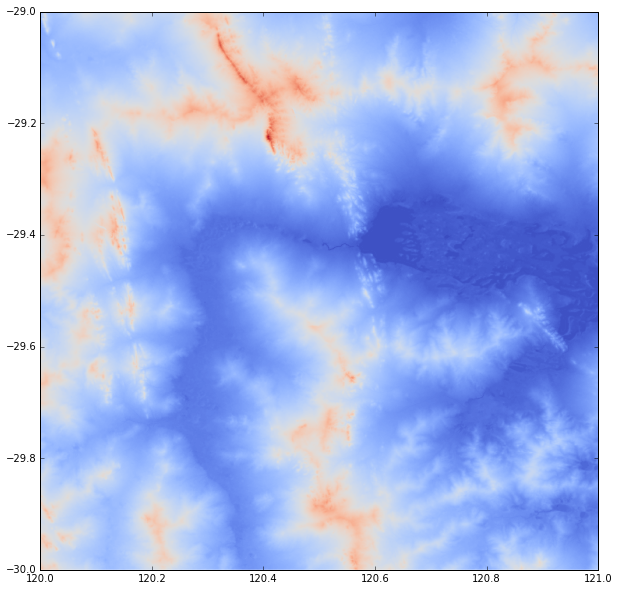

In [10]:
plot_geotiff('height.geotiff')

Repeat for aster

In [ ]:
url = 'http://aster.nci.org.au/thredds/wcs/aster/vnir/Aus_Mainland/Aus_Mainland_AlOH_group_composition_reprojected.nc4'
force_update = False

response = requests.get(url, params=get_wcs_capabilities)
response.raise_for_status()
capabilities = etree.fromstring(response.content)

# Parse capabilities document
version = xpath(capabilities, './@version')
layers = xpath(capabilities, './/wcs:CoverageOfferingBrief',
              unwrap=False)
layer_info = [{'name': xpath(layer, './wcs:name/text()'),
               'label': xpath(layer, './wcs:label/text()'),
               'description': xpath(layer, './wcs:description/text()')
              } for layer in layers]

# Do getcoverage requests
bbox = "{0[0]},{0[1]},{1[0]},{1[1]}".format(lower_left, upper_right)
params = {
    "service": "wcs",
    "request": "GetCoverage",
    "bbox": bbox,
    "width": width,
    "height": height,
    "format": "GeoTIFF",
    "version": version,
    "crs": "urn:ogc:def:crs:OGC:1.3:CRS84"
}
files = []
get_coverage_url = xpath(capabilities, './/wcs:GetCoverage//wcs:Get//@xlink:href')

# for layer in layer_info:
#     # Check whether we need to redownload
#     filename = layer["label"] + '.geotiff'
#     if os.path.exists(filename) and not force_update:
#         files.append(filename)
#         continue
        
#     # Redownload if we're here
#     params.update(coverage=layer["name"])
#     import pdb; pdb.set_trace()
#     response = requests.get(get_coverage_url, params=params,
#                             stream=True)
#     if response.ok:
#         with open(filename, 'wb') as fhandle:
#             for chunk in response.iter_content(chunk_size=int(1e5)):
#                 fhandle.write(chunk)
#         files.append(filename)
#     else:
#         import pdb; pdb.set_trace()
#         print('Server sent an error: {0}'.format(response.status_code))